Dziś pobawimy się w analizy częstotliwościowe. Będzie więcej trudniejszego kodu, którego nie musicie dokładnie rozumieć. Ważne aby podstawowe koncepty były dla Was zrozumiałe.

In [1]:
import os
import mne

In [2]:
cd C:\Users\swps\Dropbox\Sarenka\ZAJECIA\AnalizaDanychEEG\zajecia 02

C:\Users\swps\Dropbox\Sarenka\ZAJECIA\AnalizaDanychEEG\zajecia 02


In [3]:
from glob import glob

files = glob('*.set')

In [4]:
files[-1]

'sternberg_diam_054_AK.set'

Wczytujemy plik z zadaniem sternberga - prowadzący opowie o co chodzi w tym zadaniu.

In [5]:
raw = mne.io.read_raw_eeglab(files[-1], preload=True)
montage = mne.channels.read_montage('standard_1020')
raw.set_montage(montage)

The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
Events like the following will be dropped entirely: ['boundary'], 1 in total
1/2110 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
Reading sternberg_diam_054_AK.fdt
Reading 0 ... 1252712  =      0.000 ...  5010.848 secs...


<ipython-input-5-a0c49f9e7435>:1: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(files[-1], preload=True)
<ipython-input-5-a0c49f9e7435>:1: RuntimeWarning: Events like the following will be dropped entirely: ['boundary'], 1 in total
  raw = mne.io.read_raw_eeglab(files[-1], preload=True)
<ipython-input-5-a0c49f9e7435>:1: RuntimeWarning: 1/2110 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  raw = mne.io.read_raw_eeglab(files[-1], preload=True)


<RawEEGLAB  |  sternberg_diam_054_AK.fdt, n_channels x n_times : 64 x 1252713 (5010.8 sec), ~611.8 MB, data loaded>

Będziemy potrzebować trybu interaktywnego:

In [6]:
%matplotlib

Using matplotlib backend: Qt5Agg


Filtrujemy dane - przepuszczamy częstotliwości powyżej 1 Hz. Dodatkowo ustawiamy transition bandwidth na 0.5 Hz - tzn. częstotliwości w odległości do 0.5 Hz od 1 Hz powyżej którego przepuszczamy godzimy się filtrować mniej agresywnie (o tym tylko przelotnie rozmawialiśmy na zajęciach, wrzucę Wam odniesienia do literatury jeszcze, jeżeli Was to interesuje).

In [7]:
raw.filter(1, None, l_trans_bandwidth=0.5)

Setting up high-pass filter at 1 Hz
Filter length of 3300 samples (13.200 sec) selected


<RawEEGLAB  |  sternberg_diam_054_AK.fdt, n_channels x n_times : 64 x 1252713 (5010.8 sec), ~611.8 MB, data loaded>

Napisałem dla Was funkcję `spectral_reconstruction` do oglądania jak sygnał jest rekonstruowany z częstotliwości, aby z niej skorzystać musicie mieć zupdate'owane mypy.

In [8]:
from mypy.edu import spectral_reconstruction

In [9]:
spectral_reconstruction(raw, 'PO3', 48.)

C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [12]:
# poszukajmy sobie w sygnale innych ciekawych fragmentów
raw.plot(n_channels=64, scalings='auto', start=5.);

In [11]:
spectral_reconstruction(raw, 'F7', 20.)

C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [13]:
spectral_reconstruction(raw, 'Fp2', 243.)

C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


## Własnoręczne Widmo
Zrobimy teraz widmo (*psd* - od power spectral density) dla wybranej elektrody i wyświetlimy je sobie.  
O kwestiach związanych z widmem, strasznym upiorem możecie przeczytać sobie więcej na przykład tutaj:
https://en.wikipedia.org/wiki/Spectral_density

Zanim policzymy sobie widmo Twoje zadanie to:
* wybrać sobie jakąś elektrodę i zapisać jej nazwę z zmiennej `ch_name`, np.:
  ```python
  ch_name = 'Oz'
  ```
* znaleźć dla tej elektrody 10-sekundowy fragment sygnału bez znaczących artefaktów i zapisać zakres sekundowy tego zakresu w zmiennych `t_start` (początek fragmentu - w sekundach) oraz `t_end` (koniec fragmentu - również w sekundach)

In [14]:
ch_name = 'Oz'
t_start = 10.
t_end = 20.

Znajdziemy teraz indeks wybranej przez Was elektrody:

In [15]:
ch_ind = raw.ch_names.index(ch_name)

Aby zrobić widmo skorzystamy z metody Welch'a (prowadzący powinien o niej wspomnieć w kilku zdaniach wcześniej). Potrzebna będzie Nam funkcja `psd_welch` - mieszka ona w `mne.time_frequency`:

In [16]:
from mne.time_frequency import psd_welch

Jak każda funkcja mne pythona - ta również jest dobrze udokumentowana. Znajdź jej dokumentacje w sieci i przeczytaj ogólnie jakie przyjmuje argumenty.

Na początek zrobimy defaultowo, podamy tylko dane, czas, który nas interesuje oraz elektrodę (`picks`):

In [18]:
psd, freq = psd_welch(raw, tmin=t_start, tmax=t_end, picks=ch_ind)

Effective window size : 1.024 (s)


Teraz w `psd` mamy widmo w formacie macierzy numpy a w `freq` mamy informację o kolejnych częstotliwościach.
Sprawdźmy najpierw rozmiar macierzy `psd`:

In [19]:
psd.shape

(1, 129)

1 na 129 - bo wybraliśmy jedną elektrodę a `psd_welch` zwrócił nam 129 częstotliwości. O tym jakie to częstotliwości informuje nas zmienna `freq`. W związku z tym też powinna mieć długość 129, sprawdźmy to:

In [20]:
freq.shape

(129,)

Jakie to częstotliwości? Możecie zaadresować wektor `freq` np. poniżej patrzymy na pierwsze 12 wartości, które się w nim znajduje:

In [27]:
freq[:12]

array([  0.       ,   0.9765625,   1.953125 ,   2.9296875,   3.90625  ,
         4.8828125,   5.859375 ,   6.8359375,   7.8125   ,   8.7890625,
         9.765625 ,  10.7421875])

Tak jest - mamy więc moc (`psd`) kolejnych częstotliwości (`freq`).
Skorzystamy z biblioteki matplotlib aby wyrysować sobie widmo (na osi x - częstotliwości, na osi y - moc). 

In [22]:
import matplotlib.pyplot as plt

Przełączę się do trybu inline, ale Wy nie musicie tego robić.

In [23]:
%matplotlib inline

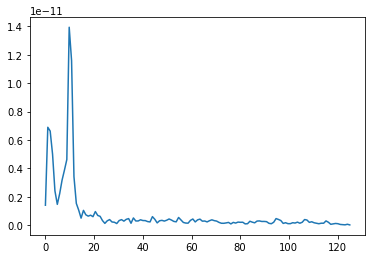

In [25]:
plt.plot(freq, psd[0, :])

`psd` adresujemy za pomocą `[0, :]` bo chcemy pierwsza elektrodę i wszystkie (`:`) częstotliwosci.
Jeżeli chcemy wyświetlić tylko pierwszych, dajmy na to 35 częśtotliwości:

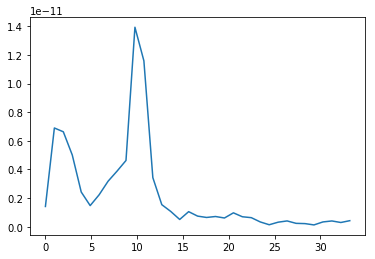

In [28]:
plt.plot(freq[:35], psd[0, :35])

Teraz chcemy pobawić się parametrami funkcji `psd_welch`. Po pierwsze - chcemy dostawać widmo tylko do 35 Hz, dalej dużo ciekawych rzeczy pewnie się nie dzieje (chyba że wybraliście element z artefaktami mięsniowymi :) ). Po drugie chcemy aby pojedynczy segment miał 3 sekundy - wtedy zyskamy rozdzielczość w częstotliwości. Długość segmentów należy podawać w próbkach czasowych a nie czasie.
Zagadka: ile próbek to 3 sekundy jeżeli w `raw.info['sfreq']` mamy podaną częstotliwość próbkowania?
Wynik zapisz w zmiennej `czas_okna`

In [29]:
czas_okna = # tutaj wpisz wynik swoich rozważań

In [30]:
psd2, freq2 = psd_welch(raw, tmin=t_start, tmax=t_end, picks=ch_ind,
                        n_fft=czas_okna, fmax=35.)

Effective window size : 3.000 (s)


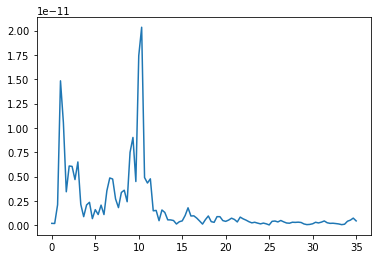

In [31]:
plt.plot(freq2, psd2[0, :])

Porównajmy wcześniejsze widmo z obecnym:

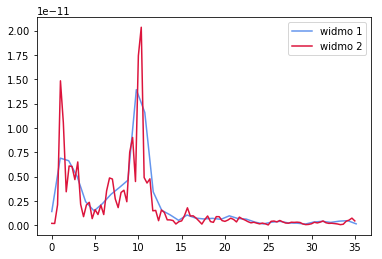

In [35]:
plt.plot(freq[:37], psd[0, :37], color='cornflowerblue', label='widmo 1')
plt.plot(freq2, psd2[0, :], color='crimson', label='widmo 2')
plt.legend(loc='best')

Zmienimy teraz wartość zmiennej `n_overlap` kontrolującej w jakim stopniu pokrywają się kolejne segmenty welcha. Obecnie ustawialiśmy `n_fft` (długość segmentu) na 3 sekundy. Ustawmy pokrycie na 2 s. Znów musisz posłużyć się `raw.info['sfreq']` aby wyliczyć ile próbek to 2 sekundy:

In [36]:
overlap = # tutaj

In [37]:
psd3, freq3 = psd_welch(raw, tmin=t_start, tmax=t_end, picks=ch_ind,
                        n_fft=czas_okna, fmax=35., n_overlap=overlap)

Effective window size : 3.000 (s)


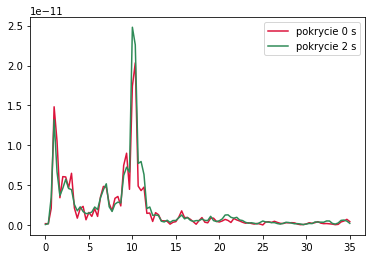

In [38]:
plt.plot(freq2, psd2[0, :], color='crimson', label='pokrycie 0 s')
plt.plot(freq3, psd3[0, :], color='seagreen', label='pokrycie 2 s')
plt.legend(loc='best')

Dlaczego widmo uzyskane z pokryciem okienek 2 s jest gładsze?

Widmo możemy też zrobić dla wielu kanałów, poniżej zrobimy widmo dla kanałów Oz, Pz i Fz: 

In [39]:
Oz = raw.ch_names.index('Oz')
Pz = raw.ch_names.index('Pz')
Fz = raw.ch_names.index('Fz')
wybrane_kanały = [Oz, Pz, Fz]

To samo co wyżej można też zrobić za pomocą tzw. list comprehensions w pythonie. Jeżeli uczycie się pythona, sprawdźcie sobie list comprehensions:
```python
wybrane_kanały = [raw.ch_names.index(kanał) for kanał in ['Oz', 'Pz', 'Fz']]
```

In [40]:
psd4, freq4 = psd_welch(raw, tmin=t_start, tmax=t_end, picks=wybrane_kanały,
                        n_fft=czas_okna, fmax=35., n_overlap=overlap)

Effective window size : 3.000 (s)


Wyrysujmy sobie widmo dla każdego z kanłów na jednym wykresie.
`psd` ma wymiary kanały na częstotliwości:

In [41]:
psd4.shape

(3, 106)

funkcja `plot` z której korzystamy, gdy podać jej macierz - wyświetli kolumny jako odzielne linie. W psd jak widzicie wyżej mamy 3 wiersze (kanały) oraz 106 kolumn (częstotliwości). Chcemy mieć oddzielne linie dla kanałów, więc powinniśmy mieć odwrotnie - kanały w kolumnach a czestotliwości w wierszach.
Całe szczęście macierz można sobie obrócić w wymiarach tzn. zrobić tak, że wymiar 2 staje się 1 i odwrotnie. Nazywa się to transpozycją i robi za pomocą metody `T`:

In [42]:
psd4.T.shape

(106, 3)

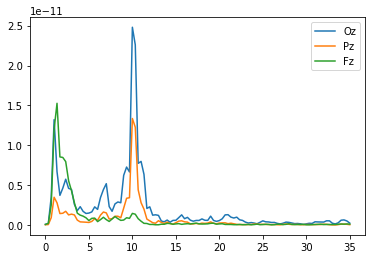

In [43]:
plt.plot(freq4, psd4.T)
plt.legend(['Oz', 'Pz', 'Fz'], loc='best')

Widzimy, że im dalej od potylicy tym mniej alfy (10 Hz). Jeżeli chcemy sobie wyświetlić topografię tej alfy możemy skorzystać z `mne.viz.plot_topomap`. Ale najpierw policzymy sobie widmo dla wszystkich kanałów, ale wybierzemy sobie przedział częstotliwościowy od 9 do 11 Hz:

In [45]:
# robimy kopię danych tylko z kanałami eeg aby ułatwić sobie dalszy krok
# (zapytaj się prowadzącego po co to - na pewno chętnie opowie)
raw_nostim = raw.copy().pick_types(eeg=True).crop(tmin=t_start, tmax=t_end)

In [47]:
psd_all, freq_all = psd_welch(raw_nostim, n_fft=czas_okna, fmin=9., fmax=11., n_overlap=overlap)

Effective window size : 3.000 (s)


Mamy teraz więcej kanałów, ale mniej częstotliwości:

In [50]:
psd_all.shape

(63, 7)

Rysujemy wszystkie kanały:

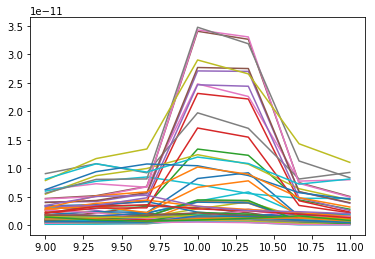

In [49]:
plt.plot(freq_all, psd_all.T);

Zrobimy sobie teraz średnią po wymiarze częstotliwości (wymiar drugi czyli wymiar o indeksie 1) aby otrzymać średnią moc pasma 9-11 Hz:

In [52]:
alpha = psd_all.mean(axis=1)

Teraz dla każdego kanału mamy jedną wartość, czas więc narysować te wartości na główce:

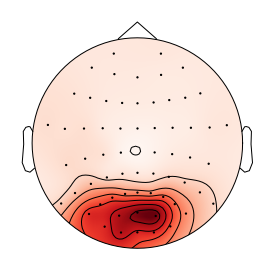

(<matplotlib.image.AxesImage at 0x1b10472f860>,
 <matplotlib.contour.QuadContourSet at 0x1b104763080>)

In [53]:
mne.viz.plot_topomap(alpha, raw_nostim.info)

Jejku, rety - cała alfa jest z tyłu głowy!

Chcemy jeszcze zobaczyć thetę, do tego potrzebujemy pociąć dane na segmenty względem okresu maintenance (przetrzymywania w pamięci informacji tzn cyfr). Wybierzemy sobie -1.5 do 0 s względem prezentacji probe'a. Czas na pobieranie wydarzeń a później epokowanie:

In [54]:
events = mne.find_events(raw)
events[:10, :]

2109 events found
Events id: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20 100 111]


array([[     1,      0,    111],
       [731765,      0,    100],
       [731890,      0,      2],
       [732015,      0,      5],
       [732140,      0,     10],
       [732265,      0,      8],
       [732390,      0,    100],
       [732932,      0,     15],
       [741428,      0,    100],
       [741578,      0,      7]], dtype=int64)

Wydarzenia 11 - 20 to prezentacja probe'a, także epokujemy względem tychże.

In [55]:
epochs = mne.Epochs(raw, events=events, event_id=[11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                    tmin=-1.5, tmax=0., preload=True, baseline=None)

281 matching events found
0 projection items activated
Loading data for 281 events and 376 original time points ...
0 bad epochs dropped


Jak zobaczyć thetę? Wykonaj poniższe kroki:
* poprzeglądaj epoki (`epochs.plot(n_channels=63)`) i kliknij do usunięcia te, które mają jakieś artefakty
* zrób widmo dla elektrody Fz i wyświetl widmo
* zrób widmo dla wszystkich elektrod dla częstotliwości 4 - 8 Hz
* uśrednij częstotliwości i wyświetl widmo na główce